Problem: We want to understand how solar + battery + load interact in a microgrid.
Later we can predict grid import or optimize battery usage.

First 5 rows of data:
                 time  load_demand  solar_generation  battery_soc  \
0 2025-08-01 00:00:00        5.298             0.000       10.000   
1 2025-08-01 01:00:00        4.917             0.000        6.667   
2 2025-08-01 02:00:00        5.389             0.124        3.333   
3 2025-08-01 03:00:00        5.914             0.000        0.000   
4 2025-08-01 04:00:00        4.860             0.000       -0.000   

   battery_power  grid_import  
0          0.000        5.298  
1         -3.333        1.584  
2         -3.333        1.931  
3         -3.333        2.580  
4         -0.000        4.860  

Shape of dataset: (336, 6)

Data summary:
                      time  load_demand  solar_generation  battery_soc  \
count                  336   336.000000        336.000000   336.000000   
mean   2025-08-07 23:30:00     5.960

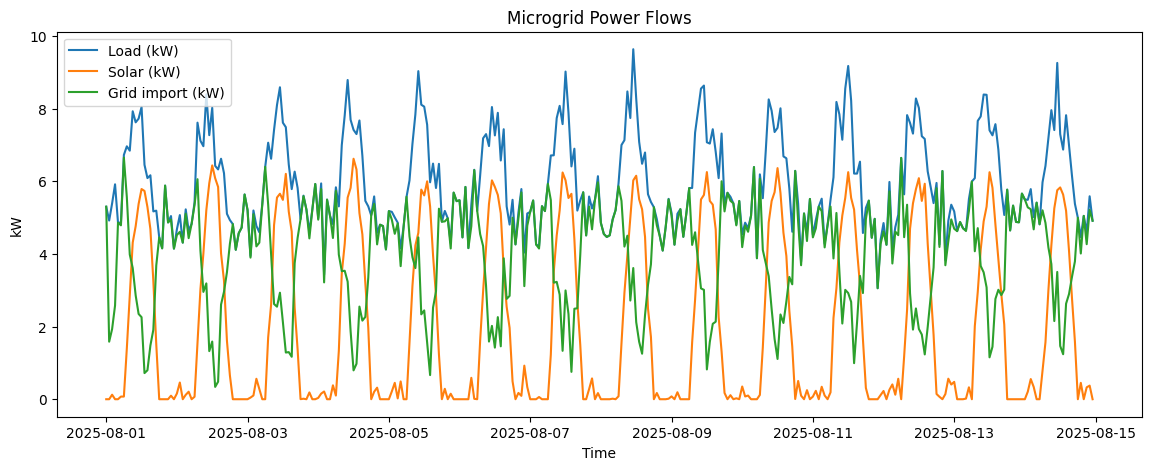

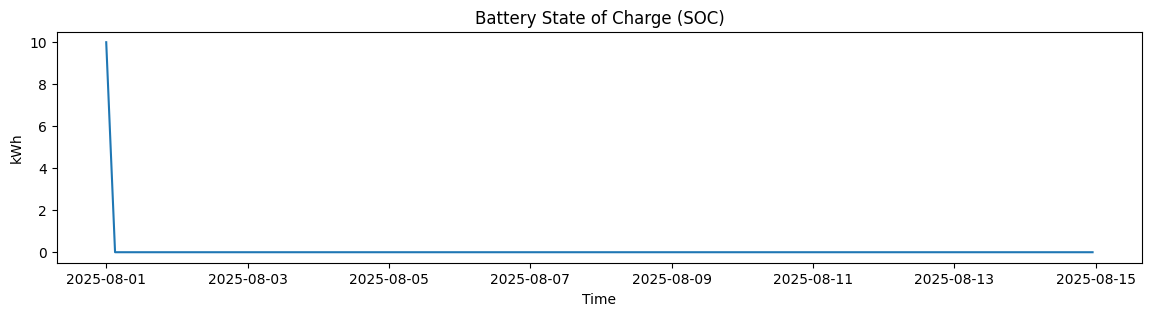


Check missing values:
time                0
load_demand         0
solar_generation    0
battery_soc         0
battery_power       0
grid_import         0
dtype: int64

Scaled data sample:
   load_demand  solar_generation  battery_soc      hour  is_day
0     0.341037          0.000000       1.0000  0.000000     0.0
1     0.283108          0.000000       0.6667  0.043478     0.0
2     0.354873          0.018737       0.3333  0.086957     0.0
3     0.434697          0.000000       0.0000  0.130435     0.0
4     0.274441          0.000000       0.0000  0.173913     0.0

Shapes after splitting:
X_train: (268, 5)
X_test: (68, 5)
y_train: (268, 1)
y_test: (68, 1)

Dataset saved as microgrid_data.csv

Week 1 complete! Data is ready for next steps.


In [11]:
# STEP 1: define the problem

print("Problem: We want to understand how solar + battery + load interact in a microgrid.")
print("Later we can predict grid import or optimize battery usage.")

# STEP 2: Data collection and understanding

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

hours = pd.date_range(start="2025-08-01 00:00", periods=24*14, freq="h")
n = len(hours)

base_load = 5.0
daily_peak = 3.0 * (np.sin((np.arange(n) % 24 - 17) * (2*np.pi/24)) * -1)
noise_load = np.random.normal(scale=0.6, size=n)
load_demand = base_load + np.maximum(0, daily_peak) + noise_load
load_demand = np.clip(load_demand, 0.5, None)

hour_of_day = hours.hour
solar_generation = np.maximum(0, 6 * np.sin((hour_of_day - 6) * (np.pi/12)))
solar_generation += np.random.normal(scale=0.3, size=n)
solar_generation = np.clip(solar_generation, 0, None)

battery_capacity = 20.0
battery_soc = np.zeros(n)
battery_soc[0] = battery_capacity * 0.5

for i in range(1, n):
    delta = solar_generation[i-1] - load_demand[i-1]
    if delta > 0:
       charge = min(delta, battery_capacity - battery_soc[i-1])
       battery_soc[i] = battery_soc[i-1] + charge * 0.9
    else:

       discharge = min(-delta,3.0, battery_soc[i-1])
       battery_soc[i] = battery_soc[i-1] - discharge / 0.9
battery_power = np.diff(battery_soc, prepend=battery_soc[0])


grid_import = load_demand - solar_generation - (-np.minimum(0, battery_power))
grid_import = np.clip(grid_import, 0, None)

# Build dataframe
data = pd.DataFrame({
    "time": hours,
    "load_demand": np.round(load_demand, 3),
    "solar_generation": np.round(solar_generation, 3),
    "battery_soc": np.round(battery_soc, 3),
    "battery_power": np.round(battery_power, 3),
    "grid_import": np.round(grid_import, 3)
})

print("\nFirst 5 rows of data:")
print(data.head())
print("\nShape of dataset:", data.shape)

# some stats to see range
print("\nData summary:")
print(data.describe())

# quick visualization to understand
plt.figure(figsize=(14,5))
plt.plot(data["time"], data["load_demand"], label="Load (kW)")
plt.plot(data["time"], data["solar_generation"], label="Solar (kW)")
plt.plot(data["time"], data["grid_import"], label="Grid import (kW)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kW")
plt.title("Microgrid Power Flows")
plt.show()

plt.figure(figsize=(14,3))
plt.plot(data["time"], data["battery_soc"], label="Battery SOC")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.title("Battery State of Charge (SOC)")
plt.show()

# STEP 3: Data preprocessing

print("\nCheck missing values:")
print(data.isnull().sum())

data["hour"] = data["time"].dt.hour
data["is_day"] = ((data["hour"] >= 6) & (data["hour"] <= 18)).astype(int)

# Select inputs and target
X = data[["load_demand", "solar_generation", "battery_soc", "hour", "is_day"]]
y = data[["grid_import"]]

# Scale features between 0 and 1 (helps ML later)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("\nScaled data sample:")
print(X_scaled.head())


# STEP 4: Data splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("\nShapes after splitting:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

data.to_csv("microgrid_data.csv", index=False)
print("\nDataset saved as microgrid_data.csv")

print("\nWeek 1 complete! Data is ready for next steps.")
